# Подгружаем все что может понадобится

In [ ]:
import pandas as pd
import numpy as np
import sys
import datetime
from random import choice
import platform
from statistics import median
import matplotlib.pyplot as plt
from sortedcontainers import SortedDict
import warnings
import math
from copy import deepcopy
from tqdm.notebook import tqdm
import matplotlib as mpl
import platform
from collections import Counter
from IPython.core.display import HTML
import os
from copy import deepcopy
import json
from statistics import median

warnings.filterwarnings('ignore')
pd.options.display.max_rows = 10000




In [6]:
!ls

LIGHT_VERSION_FOL.ipynb
Mathematical models for CorrDarkPool MM-v153-20210428_155726.pdf
OrderLog20160105
OrderLog20160105.zip
Presentation
README.md
algo_classes.py
algo_stats.py
backtest_period.py
backtest_presentation_beta.pdf
backtest_tutorial.docx
config_default.py
create_jsons.py
hard backtest.ipynb
helpers.py
iseberg_detector.py
old_scripts
optimizations
path_generator.py
~$cktest_tutorial.docx


# Посмотрим на наши данные и почистим их

In [8]:

fol = pd.read_csv("OrderLog20160105/OrderLog20160105.txt", sep=',')
fol["TRADENO"] = fol["TRADENO"].astype(str)
fol.tail(2)

,NO,SECCODE,BUYSELL,TIME,ORDERNO,ACTION,PRICE,VOLUME,TRADENO,TRADEPRICE
6526987,6526988,ALRS,B,184459117,3028350,0,56.5000,1000,nan,NaN
6526988,6526989,SU52001RMFS3,S,184459356,3130180,0,99.9798,3,nan,NaN


In [9]:


count = Counter(fol["SECCODE"]).most_common(3)
out = []
for share in count:
    out.append(share[0])
count

[('GAZP', 1110567), ('LKOH', 543685), ('SBER', 539873)]

#  Соберем стакан из этого

Общая идея взята из статьи - https://habr.com/ru/post/276635/

# Для корректной работы бектеста и чтобы стакан сходился необходимо научится вычислять айсберги

### Сделано это было следующим образом - сверять у каждой заявки объем поторгованного и выставленного - и если объем поторгованного больше, то это точно айсберг и заменяем ему объем на сумму всего поторгованного. Здесь эта часть не показана. И тут просто подгружаются готовые файлы

In [61]:
date = "20160105"
share = "GAZP"
data = fol[fol["SECCODE"] == share]
data = data[data["ACTION"] != 2] # выкидываем информацию о сделках и сами будем ее генерировать
data["DATE"] = date
records = data.to_dict("records")
data.reset_index(inplace=True)
data.shape

(1069443, 12)

In [62]:
data.head()

,index,NO,SECCODE,BUYSELL,TIME,ORDERNO,ACTION,PRICE,VOLUME,TRADENO,TRADEPRICE,DATE
0,90,91,GAZP,B,100000000,91,1,132.21,120,nan,NaN,20160105
1,133,134,GAZP,S,100000000,134,1,136.34,110,nan,NaN,20160105
2,134,135,GAZP,S,100000000,135,1,135.97,110,nan,NaN,20160105
3,135,136,GAZP,S,100000000,136,1,136.83,110,nan,NaN,20160105
4,138,139,GAZP,S,100000000,139,1,137.55,20,nan,NaN,20160105


In [79]:
class Matching_Engine:
    def __init__(self):
        self.bid = SortedDict()  # descending
        self.ask = SortedDict()
        self.bid_active_order = dict()
        self.ask_active_order = dict()
        self.bid_FIFO = dict()
        self.ask_FIFO = dict()
        self.day = None
        self.share_name = "LKOH"
        self.trade_log = []

    def check_order(self, data):
        if self.day != data["DATE"]:
            self.clean_dom()
            self.share_name = data["SECCODE"]
            self.day = data["DATE"]

        if data["ACTION"] == 1:
            return self.check_add(data, new_trades=[])
        elif data["ACTION"] == 2:
            pass
        else:
            self.delete_order(data)

    ## First part - adding order

    def check_add(self, data, rec_flag=False, new_trades=[]):
        if (len(self.ask) > 0 and data['BUYSELL'] == "B" and
            (data["PRICE"] >= self.ask.peekitem(0)[0] or data["PRICE"] < 0.000001)) or \
                (len(self.bid) > 0 and data['BUYSELL'] == "S" and data["PRICE"] <= self.bid.peekitem(-1)[0]):
            if not rec_flag:
                self.add_order(data)
            return self.trade(data, new_trades=new_trades)
        else:
            if not rec_flag:
                self.add_order(data)

    def add_order(self, data):
        if data['BUYSELL'] == "B":
            self.bid_active_order[data["ORDERNO"]] = (data["PRICE"], data["VOLUME"])
            if data["PRICE"] not in self.bid:
                self.bid[data["PRICE"]] = data["VOLUME"]
                self.bid_FIFO[data["PRICE"]] = [data["ORDERNO"]]
            else:
                self.bid[data["PRICE"]] += data["VOLUME"]
                self.bid_FIFO[data["PRICE"]].append(data["ORDERNO"])
        else:
            self.ask_active_order[data["ORDERNO"]] = (data["PRICE"], data["VOLUME"])
            if data["PRICE"] not in self.ask:
                self.ask[data["PRICE"]] = data["VOLUME"]
                self.ask_FIFO[data["PRICE"]] = [data["ORDERNO"]]
            else:
                self.ask[data["PRICE"]] += data["VOLUME"]
                self.ask_FIFO[data["PRICE"]].append(data["ORDERNO"])

    ## Second part - delete order

    def delete_order(self, data):
        if data['BUYSELL'] == "B":
            self.bid_FIFO[data["PRICE"]].pop(self.bid_FIFO[data["PRICE"]].index(data["ORDERNO"]))
            self.bid[data["PRICE"]] -= self.bid_active_order[data["ORDERNO"]][1]
            if len(self.bid_FIFO[data["PRICE"]]) < 1:
                del self.bid_FIFO[data["PRICE"]]
            del self.bid_active_order[data["ORDERNO"]]
            if self.bid[data["PRICE"]] < 0.000000001:
                del self.bid[data["PRICE"]]
        else:
            self.ask[data["PRICE"]] -= self.ask_active_order[data["ORDERNO"]][1]
            self.ask_FIFO[data["PRICE"]].pop(self.ask_FIFO[data["PRICE"]].index(data["ORDERNO"]))
            if len(self.ask_FIFO[data["PRICE"]]) < 1:
                del self.ask_FIFO[data["PRICE"]]
            del self.ask_active_order[data["ORDERNO"]]
            if self.ask[data["PRICE"]] < 0.000000001:
                del self.ask[data["PRICE"]]

    ## Third part - match order
    def trade(self, data, new_trades=[]):
        if data['BUYSELL'] == "B":
            return self.exec_buy_order(data, new_trades=new_trades)
        else:
            return self.exec_sell_order(data, new_trades=new_trades)

    def exec_sell_order(self, data, new_trades=[]):
        go_trade = True
        while go_trade:
            go_trade = False
            sell_order = self.ask_active_order[data["ORDERNO"]]
            tradeprice = self.bid.peekitem(-1)[0]
            order_no = self.bid_FIFO[tradeprice][0]
            if str(order_no)[0] == 'm':
                out_no = "mm_past"
            else:
                out_no = order_no
            buy_order = self.bid_active_order[order_no]
            if buy_order[1] > sell_order[1]:
                self.bid_active_order[order_no] = (self.bid_active_order[order_no][0],
                                                   buy_order[1] - sell_order[1])
                trade_vol = sell_order[1]
                self.bid[buy_order[0]] -= trade_vol
                self.delete_order(data)
            elif buy_order[1] == sell_order[1]:
                self.delete_order(data)
                tmp = dict()
                tmp["BUYSELL"] = "B"

                tmp["PRICE"] = buy_order[0]
                tmp["ORDERNO"] = order_no

                self.delete_order(tmp)
                trade_vol = sell_order[1]
            else:
                # iseberg or error
                tmp = dict()
                tmp["BUYSELL"] = "B"
                tmp["PRICE"] = buy_order[0]
                tmp["ORDERNO"] = order_no
                self.delete_order(tmp)
                trade_vol = buy_order[1]
                self.ask[sell_order[0]] -= trade_vol
                self.ask_active_order[data["ORDERNO"]] = (self.ask_active_order[data["ORDERNO"]][0],
                                                          sell_order[1] - buy_order[1])
                # TODO не учтено полное пробитие стакана!!
                if len(self.bid) == 0:
                    # reject стакан пробит
                    go_trade = False
                if self.bid.peekitem(-1)[0] >= sell_order[0] or data["PRICE"] < 0.000000001:
                    go_trade = True

            self.trade_log.append(
                [tradeprice, trade_vol, data["ORDERNO"], out_no, tradeprice * trade_vol, data["TIME"], data["NO"], "S"])
            new_trades.append(self.trade_log[-1])
            if buy_order[1] < 0 or sell_order[1] < 0:
                print("Maybe error", buy_order, sell_order)
                raise Exception(buy_order, sell_order)
            if go_trade:
                data["VOLUME"] -= trade_vol
                self.ask_active_order[data["ORDERNO"]] = (self.ask_active_order[data["ORDERNO"]][0], data["VOLUME"])
                # self.ask[data["PRICE"]] -= data["VOLUME"]
                # return self.check_add(data, rec_flag=True, new_trades=new_trades)
        return new_trades

    def exec_buy_order(self, data, new_trades=[]):
        go_trade = True
        while go_trade:
            go_trade = False
            buy_order = self.bid_active_order[data["ORDERNO"]]
            tradeprice = self.ask.peekitem(0)[0]
            order_no = self.ask_FIFO[tradeprice][0]
            if str(order_no)[0] == 'm':
                out_no = "mm_past"
            else:
                out_no = order_no
            sell_order = self.ask_active_order[order_no]
            if sell_order[1] > buy_order[1]:
                self.ask_active_order[order_no] = (self.ask_active_order[order_no][0],
                                                   sell_order[1] - buy_order[1])
                trade_vol = buy_order[1]
                self.ask[sell_order[0]] -= trade_vol
                self.delete_order(data)
            elif buy_order[1] == sell_order[1]:
                self.delete_order(data)
                tmp = dict()
                tmp["BUYSELL"] = "S"
                tmp["PRICE"] = sell_order[0]
                tmp["ORDERNO"] = self.ask_FIFO[tradeprice][0]
                self.delete_order(tmp)
                trade_vol = sell_order[1]
            else:
                # iseberg or error
                tmp = dict()
                tmp["BUYSELL"] = "S"
                tmp["PRICE"] = sell_order[0]
                tmp["ORDERNO"] = order_no
                self.delete_order(tmp)
                trade_vol = sell_order[1]
                self.bid[buy_order[0]] -= trade_vol
                self.bid_active_order[data["ORDERNO"]] = (self.bid_active_order[data["ORDERNO"]][0],
                                                          buy_order[1] - sell_order[1])
                if len(self.ask) == 0:
                    # reject стакан пробит
                    go_trade = False
                if self.ask.peekitem(0)[0] <= buy_order[0] or data["PRICE"] < 0.000000001:
                    go_trade = True

            # TODO Мне кажется здесь потенциальная ошибка, не предусмотрено что аркет мейкер заявка может в кого то удариться
            self.trade_log.append(
                [tradeprice, trade_vol, data["ORDERNO"], out_no, tradeprice * trade_vol, data["TIME"], data["NO"], "B"])
            new_trades.append(self.trade_log[-1])
            if buy_order[1] < 0 or sell_order[1] < 0:
                print("Maybe error", buy_order, sell_order)
                raise Exception(buy_order, sell_order)
            if go_trade:
                data["VOLUME"] -= trade_vol
                self.bid_active_order[data["ORDERNO"]] = (self.bid_active_order[data["ORDERNO"]][0], data["VOLUME"])
                # self.bid[data["PRICE"]] -= data["VOLUME"]
                return self.check_add(data, rec_flag=True, new_trades=new_trades)
        return new_trades

    ## Others

    def clean_dom(self):
        self.__init__()


In [80]:
dom = Matching_Engine()
errors = 0
isebergs = pd.read_csv("OrderLog" + date + "/isebergs_" + share + date + ".csv", index_col=0).to_dict()["vol"]

for i in tqdm(range(len(records))):
    record = records[i].copy()
    if record["ACTION"] == 1 and record["ORDERNO"] in isebergs:
        record["VOLUME"] = isebergs[record["ORDERNO"]]
    try:
        out = dom.check_order(record)
    except Exception as e:
        if record["ACTION"] == 1:
            print("MAYBE Some problem, cant add order")
            dom.check_order(record)
            raise Exception
        errors += 1

100%|██████████| 1069443/1069443 [00:04<00:00, 232380.37it/s]


# Теперь воспроизведем базовую версию алгоритма и проведем ее бектест

In [81]:
def myround(x, prec=6, base=.1):
    return round(base * round(float(x)/base),prec)
myround(10.6345344)

10.6

In [123]:
class Basic_MM:
    def __init__(self, spread=0.005, barriers=None, sma_len=300, basic_volume=30, price_step=.1, cash=1000000):
        self.name = "Basic MM"
        self.cash = cash
        self.first_cash = cash
        self.equity = []
        self.time = []
        self.num_of_shares = 0
        self.spread = spread
        self.price_step = price_step
        self.sma_len = sma_len
        self.basic_volume = basic_volume
        self.baseline_price = None
        self.ask_price_1 = 0
        self.ask_volume_1 = 0
        self.bid_price_1 = 0
        self.bid_volume_1 = 0
        self.bid_order_num = 0
        self.ask_order_num = 0
        self.bid_lst = []
        self.ask_lst = []
        self.volume_lst = []
        self.bid_last_price = None
        self.ask_last_price = None
        self.last_trade_num = None
        self.trigger_time = None
        self.latency_moex = 3
        self.algo_params = "\n\nAlgo name - " + self.name + "\nSpread - " + str(spread * 100) + "%,\n" + \
                           "SMA tick length - " + str(sma_len) + ",\n" + "Order volume - " + str(basic_volume) + \
                           ",\nSpeed of orders - " + str(self.latency_moex) + "ms."
        self.share_name = "LKOH"

    def trading(self, dom, time=100000000, first_sma=0, is_plot=False, is_PL=False):
        if len(dom.trade_log) < 30:
            return []
        if not self.baseline_price:
            if first_sma == 0:
                print("no first price")
                first_sma = dom.trade_log[-1][0]
            self.share_name = dom.share_name
            self.create_pre_trade_value(first_sma)
            return self.generate_orders()
        else:
            if len(dom.trade_log) < 30:
                if not self.share_name:
                    self.share_name = dom.share_name
                    self.algo_params = "Share name - " + dom.share_name + self.algo_params
                self.equity.append(self.cash + self.num_of_shares * self.baseline_price)
            else:
                self.equity.append(self.cash + self.num_of_shares * dom.trade_log[-1][0])
            self.time.append(time // 100000)
            self.volume_lst.append(self.num_of_shares * self.baseline_price)
            if len(dom.trade_log) > 30:
                if self.last_trade_num == dom.trade_log[-1][-2]:
                    pass
                elif self.trigger_time == None:
                    self.trigger_time = int(dom.trade_log[-1][-3]) + self.latency_moex
                elif int(self.trigger_time) + 100 > time:
                    pass
                else:
                    # print(time)
                    self.trigger_time = None
                    self.last_trade_num = dom.trade_log[-1][-2]
                    self.calc_bid_ask(dom.trade_log)
                    self.bid_lst.append(self.bid_price_1)
                    self.ask_lst.append(self.ask_price_1)
                    return self.generate_orders(time)
            self.bid_lst.append(self.bid_price_1)
            self.ask_lst.append(self.ask_price_1)
        return []

    def create_pre_trade_value(self, first_sma):
        self.baseline_price = first_sma
        self.ask_price_1 = myround(first_sma * (1 + self.spread / 2), base=self.price_step[self.share_name])
        self.bid_price_1 = myround(first_sma * (1 - self.spread / 2), base=self.price_step[self.share_name])
        self.ask_volume_1 = self.basic_volume
        self.bid_volume_1 = self.basic_volume

    def calc_bid_ask(self, trade_log):
        if len(trade_log) < 3:
            pass
        else:
            # TODO trde log накапливается и эта операция становиться сложной
            self.baseline_price = np.array(trade_log[-self.sma_len:])[:, 0].astype(float).mean()
            self.ask_price_1 = myround(self.baseline_price * (1 + self.spread / 2),
                                       base=self.price_step[self.share_name])
            self.bid_price_1 = myround(self.baseline_price * (1 - self.spread / 2),
                                       base=self.price_step[self.share_name])
            self.ask_volume_1 = self.basic_volume
            self.bid_volume_1 = self.basic_volume

    def generate_orders(self, time=100000000):
        bid_cancel, ask_cancel, bid_place, ask_place = dict(), dict(), dict(), dict()
        bid_cancel["BUYSELL"] = "B"
        bid_place["BUYSELL"] = "B"
        ask_cancel["BUYSELL"] = "S"
        ask_place["BUYSELL"] = "S"
        bid_cancel["ACTION"] = 0
        bid_place["ACTION"] = 1
        ask_cancel["ACTION"] = 0
        ask_place["ACTION"] = 1

        if self.bid_last_price:
            bid_cancel["PRICE"] = self.bid_last_price
            bid_cancel["ORDERNO"] = "myorder" + str(self.bid_order_num)
            ask_cancel["PRICE"] = self.ask_last_price
            ask_cancel["ORDERNO"] = "myorder" + str(self.ask_order_num)
            self.bid_order_num += 1
            self.ask_order_num += 1

        bid_place["PRICE"] = self.bid_price_1
        ask_place["PRICE"] = self.ask_price_1
        bid_place["TIME"] = time
        ask_place["TIME"] = time
        bid_place["VOLUME"] = self.bid_volume_1
        ask_place["VOLUME"] = self.ask_volume_1
        bid_place["ORDERNO"] = "myorder" + str(self.bid_order_num)
        ask_place["ORDERNO"] = "myorder" + str(self.ask_order_num)
        bid_place["NO"] = "mm"
        ask_place["NO"] = "mm"
        self.bid_last_price = self.bid_price_1
        self.ask_last_price = self.ask_price_1

        if int(self.cash) < int(self.bid_price_1 * self.bid_volume_1):
            # print("No cash")
            return [ask_cancel, ask_place]
        elif int(self.cash) > int(self.ask_price_1 * self.ask_volume_1) + 2 * int(self.first_cash):
            # print("Too much shorts")
            return [bid_cancel, bid_place]
        elif self.bid_order_num != 0:
            return [bid_cancel, ask_cancel, bid_place, ask_place]
        else:
            return [bid_place, ask_place]

    def change_cash_share(self, new_trades):
        if not new_trades or len(new_trades) == 0 or new_trades[0] == None:
            return self.cash, self.num_of_shares
        trade_log = np.array(new_trades)

        active_exec = trade_log[np.where(trade_log[:, 6] == "mm")]
        passive_exec = trade_log[np.where(trade_log[:, 3] == "mm_past")]

        if active_exec.shape[0] + passive_exec.shape[0] == 0:
            return self.cash, self.num_of_shares
        if active_exec.shape[0] > 0:
            self.num_of_shares += np.sum(
                active_exec[np.where(active_exec[:, 7] == "B")][:, 1].astype(np.float)) - np.sum(
                active_exec[np.where(active_exec[:, 7] == "S")][:, 1].astype(np.float))
            self.cash += np.sum(active_exec[np.where(active_exec[:, 7] == "S")][:, 4].astype(np.float)) - np.sum(
                active_exec[np.where(active_exec[:, 7] == "B")][:, 4].astype(np.float))
        if passive_exec.shape[0] > 0:
            self.cash += np.sum(passive_exec[np.where(passive_exec[:, 7] == "B")][:, 4].astype(np.float)) - np.sum(
                passive_exec[np.where(passive_exec[:, 7] == "S")][:, 4].astype(np.float))
            self.num_of_shares += np.sum(
                passive_exec[np.where(passive_exec[:, 7] == "S")][:, 1].astype(np.float)) - np.sum(
                passive_exec[np.where(passive_exec[:, 7] == "B")][:, 1].astype(np.float))

        return self.cash, self.num_of_shares




In [124]:
params = {'basic_volume': 1320000, 'cash': 2000000, 
          'price_step': {'GAZP': 0.01, 'SBER': 0.01, 'AFKS': 0.001, 'LKOH': 0.1, 'SNGS': 0.05, 'HYDR': 0.0001, 'TATN': 0.1, 'SNGSP': 0.005, 'ROSN': 0.05, 'RTKM': 0.01, 'URKA': 0.01, 'GMKN': 2, 'MTSS': 0.05, 'FEES': 2e-05, 'NLMK': 0.02, 'MGNT': 0.5, 'CHMF': 0.2, 'VTBR': 5e-06, 'SBERP': 0.01, 'ALRS': 0.01, 'MAGN': 0.005, 'MOEX': 0.01, 'NVTK': 0.2, 'TATNP': 0.1, 'IRAO': 0.2, 'AKRN': 2, 'PIKK': 0.1, 'POLY': 0.1, 'LSRG': 0.2, 'MTLR': 0.01}, 
          'spread': 0.002, 'sma_len': 20}
# Здесь сверху можно поменять параметры если хочется


dom = Matching_Engine()
algo = Basic_MM(**params)
#algo.trading(dom, first_sma=records[1000]["PRICE"])

In [125]:
from tqdm import tqdm 


dom = Matching_Engine()
errors = 0

isebergs = pd.read_csv("OrderLog" + date + "/isebergs_" + share + date + ".csv", index_col=0).to_dict()["vol"]
latency = 3 # ms
algo = Basic_MM(**params)
algo_errors = 0
algo_orders = None

for i in tqdm(range(len(records))):
    record = records[i].copy()
    if algo_orders and int(record["TIME"]) > algo_orders[-1]["TIME"] + latency:
        out_algo = []
        for order in algo_orders:
            order["DATE"] = date
            try:
                out = dom.check_order(order)
                if out:
                    out_algo.extend(out)
            except KeyboardInterrupt:
                break
            except:
                if order["ACTION"] == 1:
                    print("MAYBE Some problem, cant add order")
                    dom.check_order(order)
                    
                algo_errors += 1
        algo_orders = None
        if len(out_algo) > 0:
            algo.change_cash_share(out_algo)
   
    if record["ACTION"] == 1 and record["ORDERNO"] in isebergs:
        record["VOLUME"] = isebergs[record["ORDERNO"]]
    try:
        out = dom.check_order(record)
        algo.change_cash_share(out)
    except KeyboardInterrupt:
        break
    except:
        if record["ACTION"] == 1:
            print("MAYBE Some problem, cant add record")
            raise Exception
        errors += 1
    if not algo_orders:
        algo_orders = algo.trading(dom, time=record["TIME"])

  3%|▎         | 32708/1069443 [00:00<00:09, 107800.07it/s]

no first price


100%|██████████| 1069443/1069443 [00:08<00:00, 127038.92it/s]


### Бектест проведен теперь посмотрим на статистику

In [126]:
trade_log = pd.DataFrame((dom.trade_log), 
             columns=["PRICE", 'VOLUME', 'NEW-ORDER-ID', 'PAST-ORDER-ID',"TURNOVER","TIME",'NO', 'BUYSELL'])

algo_raw = pd.concat([trade_log[trade_log["NEW-ORDER-ID"].apply(isinstance, args=(str,))], 
                      trade_log[trade_log["PAST-ORDER-ID"].apply(isinstance, args=(str,))]])



# Здесь функции подсчитывающие статистики для бектеста

In [127]:
import matplotlib.dates as mdates


def get_deal(raw):
    active_exec = raw[raw["NO"] == "mm"]
    passive_exec = raw[raw["NO"] != "mm"]
    
    bid_deal = pd.concat([active_exec[active_exec["BUYSELL"] == "B"], \
    passive_exec[passive_exec["BUYSELL"] == "S"]])
    ask_deal = pd.concat([active_exec[active_exec["BUYSELL"] == "S"], \
    passive_exec[passive_exec["BUYSELL"] == "B"]])
    
    return bid_deal["TIME"] // 100000, ask_deal["TIME"] // 100000, bid_deal["PRICE"], ask_deal["PRICE"]
    

def p_l_calc(raw, fair_price):
    # PL = Bought*(FP-AvgBid) + Sold*(AvgAsk-FP)
    active_exec = raw[raw["NO"] == "mm"]
    passive_exec = raw[raw["NO"] != "mm"]
    
    bought_vol = sum(active_exec[active_exec["BUYSELL"] == "B"]["VOLUME"]) + \
    sum(passive_exec[passive_exec["BUYSELL"] == "S"]["VOLUME"])
    sold_vol = sum(active_exec[active_exec["BUYSELL"] == "S"]["VOLUME"]) + \
    sum(passive_exec[passive_exec["BUYSELL"] == "B"]["VOLUME"])
    
    if bought_vol >= 1:
        avg_bought = (sum(active_exec[active_exec["BUYSELL"] == "B"]["TURNOVER"]) + \
        sum(passive_exec[passive_exec["BUYSELL"] == "S"]["TURNOVER"])) / bought_vol
    else:
        avg_bought = 0
    if sold_vol >= 1:
        avg_sold = (sum(active_exec[active_exec["BUYSELL"] == "S"]["TURNOVER"]) + \
        sum(passive_exec[passive_exec["BUYSELL"] == "B"]["TURNOVER"])) / sold_vol
    else:
        avg_sold = 0
    
    return round(bought_vol * (fair_price - avg_bought) + sold_vol * (avg_sold - fair_price), 1), \
            bought_vol, sold_vol, round(avg_bought), round(avg_sold)
    

def algo_stats(raw, fair_price, first_trade, algo, date, trade_log, dom, share="LKOH", bid_ask=False, show_deals=False):
    print("Stats for date -", date)
    print("Algo Params: ")
    print(algo.algo_params)
    print()
    print("Num of trades - ", raw.shape[0])
    print("Algo turnover - ", round(sum(raw["PRICE"] * raw["VOLUME"]), 1))
    p_l, bought_vol, sold_vol, avg_bought, avg_sold = p_l_calc(raw, fair_price)
    print("P&L Gross - ", p_l)
    print("P&L Net(with commision) -", round(p_l - sum(raw["PRICE"] * raw["VOLUME"]) * 0.00008, 1))
    print("Num of bought - ", bought_vol)
    print("Weighted average bought price - ", avg_bought)
    print("Num of sold - ", sold_vol)
    print("Weighted average sold price - ", avg_sold)
    print("Open Price - ", first_trade)
    print("Close price - ", dom.trade_log[-1][0])
    print("Initial cash - ", algo.first_cash)
    print("Total Return - ", round(100 * p_l / algo.first_cash, 2), "%", sep="")
    mpl.style.use("seaborn")
    fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(20, 12))
    axs[0, 0].set_title(algo.name + ' - Algo Equity in % at ' + str(date)[:4] + "/" + str(date)[4:6] + "/" + str(date)[6:], size=16)
    if algo.name[:4] != "Hard":
        print("End Cash - ", round(algo.cash))
        print("End Equity - ", round(algo.cash + (bought_vol - sold_vol) * fair_price))
        print("Max day Drawdown - ", round((min(algo.equity) / algo.first_cash - 1) * 100, 2), "%", sep ='')
        axs[0, 0].plot(pd.to_datetime(pd.Series(algo.time).astype(str), format="%H%M"), np.array(algo.equity) / algo.first_cash * 100)
        axs[0, 1].set_title(share + " Price at " + str(date)[:4] + "/" + str(date)[4:6] + "/" + str(date)[6:], size=16)
        axs[1, 0].plot(pd.to_datetime(pd.Series(algo.time).astype(str), format="%H%M"), np.array(algo.volume_lst))
    
    else:
        print("End Cash - ", round(algo.cash[share]))
        print("End Equity - ", round(algo.cash[share] + (bought_vol - sold_vol) * fair_price))
        print("Max day Drawdown - ", round((min(algo.equity[share]) / algo.first_cash - 1) * 100, 2), "%", sep ='')
        axs[0, 0].plot(pd.to_datetime(pd.Series(algo.time[share]).astype(str), format="%H%M"), np.array(algo.equity[share]) / algo.first_cash * 100)
        axs[0, 1].set_title(share + " Bid/Ask Pricing at " + str(date)[:4] + "/" + str(date)[4:6] + "/" + str(date)[6:], size=16)
        axs[1, 0].plot(pd.to_datetime(pd.Series(algo.time[share]).astype(str), format="%H%M"), np.array(algo.volume_lst[share]))
    
    axs[0, 1].plot(pd.to_datetime(trade_log["TIME"], format="%H%M%S%f"), trade_log["PRICE"])
    if bid_ask:
        if algo.name[:4] == "Hard":
            axs[0, 1].plot(pd.to_datetime(pd.Series(algo.time[share]).astype(str), format="%H%M"), np.array(algo.bid_lst[share]), color="green", label="Bid")
            axs[0, 1].plot(pd.to_datetime(pd.Series(algo.time[share]).astype(str), format="%H%M"), np.array(algo.ask_lst[share]), color="red", label="Ask")
        else:
            axs[0, 1].plot(pd.to_datetime(pd.Series(algo.time).astype(str), format="%H%M"), np.array(algo.bid_lst), color="green", label="Bid")
            axs[0, 1].plot(pd.to_datetime(pd.Series(algo.time).astype(str), format="%H%M"), np.array(algo.ask_lst), color="red", label="Ask")
        
        #axs[0, 1].scatter(pd.to_datetime(pd.Series(algo.time[share]).astype(str), format="%H%M"), np.array(algo.baseline_lst[share]))
    axs[1, 0].set_title(share + ' - Algo Volume in cash ' + str(date)[:4] + "/" + str(date)[4:6] + "/" + str(date)[6:], size=16)
    axs[0, 0].set_xlabel('Time')
    axs[0, 0].set_ylabel('% of equity')
    axs[0, 1].set_xlabel('Time')
    axs[0, 1].set_ylabel('Price')
    axs[1, 0].set_xlabel('Time')
    axs[1, 0].set_ylabel('Portfolio equity')
    axs[1, 1].set_xlabel('Time')
    axs[1, 1].set_ylabel('Price')
    axs[1, 1].set_title(share + ' - Bid/Ask Deal ' + str(date)[:4] + "/" + str(date)[4:6] + "/" + str(date)[6:], size=16)
    time_bid, time_ask, bid_deal, ask_deal = get_deal(raw)
    axs[1, 1].scatter(pd.to_datetime(pd.Series(time_bid).astype(str), format="%H%M"), np.array(bid_deal), color="green", label="Bid")
    axs[1, 1].scatter(pd.to_datetime(pd.Series(time_ask).astype(str), format="%H%M"), np.array(ask_deal), color="red", label="Ask")
    axs[1, 1].legend(fontsize=13)    
    if show_deals:
        axs[0, 1].scatter(pd.to_datetime(pd.Series(time_bid).astype(str), format="%H%M"), np.array(bid_deal), color="darkgreen", label="Bid deal")
        axs[0, 1].scatter(pd.to_datetime(pd.Series(time_ask).astype(str), format="%H%M"), np.array(ask_deal), color="darkred", label="Ask deal")
    axs[0, 1].legend(fontsize=13)
    myFmt = mdates.DateFormatter('%H:%M')
    axs[0, 0].xaxis.set_major_formatter(myFmt)
    axs[0, 1].xaxis.set_major_formatter(myFmt)
    axs[1, 0].xaxis.set_major_formatter(myFmt)
    axs[1, 1].xaxis.set_major_formatter(myFmt)
    plt.show()
    plt.clf()

#algo_stats(algo_raw, dom.trade_log[-1][0], dom.trade_log[0][0], algo, date, trade_log, dom, share="LKOH", bid_ask=True, show_deals=True)


Stats for date - 20160105
Algo Params: 


Algo name - Basic MM
Spread - 0.2%,
SMA tick length - 20,
Order volume - 1320000,
Speed of orders - 3ms.

Num of trades -  40
Algo turnover -  6115058.2
P&L Gross -  -25268.0
P&L Net(with commision) - -25757.2
Num of bought -  0
Weighted average bought price -  0
Num of sold -  45060
Weighted average sold price -  136
Open Price -  134.85
Close price -  136.27
Initial cash -  2000000
Total Return - -1.26%
End Cash -  8115058
End Equity -  1974732
Max day Drawdown - -3.37%


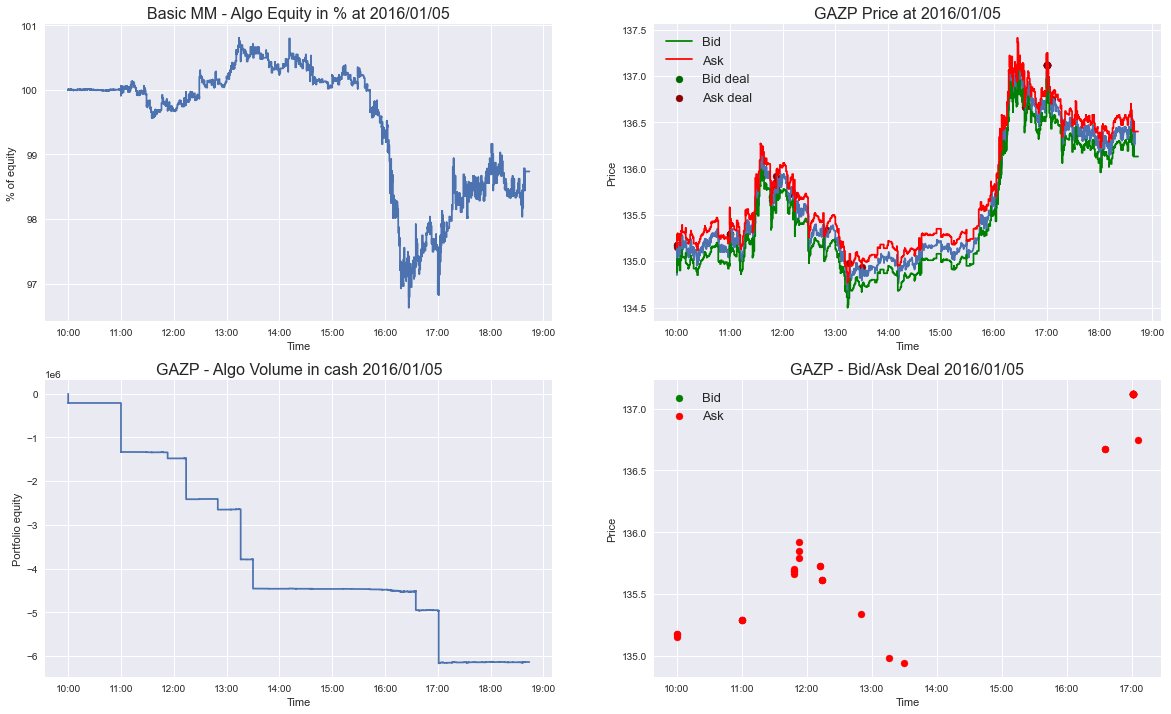

<Figure size 576x396 with 0 Axes>

In [128]:
algo_stats(algo_raw, dom.trade_log[-1][0], dom.trade_log[0][0], algo, date, trade_log, dom, bid_ask=True, show_deals=True, share=share)


# Продолжение в hard backtest